<a href="https://colab.research.google.com/github/Fabio-RibeiroB/BBK-Applied-ML/blob/main/BBK_AML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Coursework - Cyberattack Classifier

Author: Fabio Ribeiro Brady (some code is inspired from the lab and the web)

Acknowledgments: Thanks to our teachers Paul and Seongil, fellow students Hanif and Charlton, and Jie for their help.

## Connect Google Drive and Import Necessary Libraries

In [ ]:
from pandas import read_csv
from pandas import set_option
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.regularizers import l1 
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import set_printoptions 
from tensorflow.keras.models import load_model
from pandas.core.frame import DataFrame
from pandas import merge 
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from os import path
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)
import json
from scipy import stats
from keras.callbacks import ModelCheckpoint, TensorBoard
#from keras import regularizers
#from keras import optimizers
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

Either Mount your drive with the data or upload it to colab. If you don't mount
then ignore this cell.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you don't mount Google drive then upload the files on the left-hand side
on colab and run the next cell. 

If you do have drive, change the *root* variable below to your directory in
google drive that has the datasets.

## Loading the Data

In [ ]:
# Training and Test sets

root ='/content/drive/MyDrive/AML Data/' # path for my data in google drive
try:
  
  if path.isdir(root):
    
    train_csv = root +  'train_imperson_without4n7_balanced_data.csv'
    test_csv = root +  'test_imperson_without4n7_balanced_data.csv'

  else:
    train_csv = 'train_imperson_without4n7_balanced_data.csv'
    test_csv = 'test_imperson_without4n7_balanced_data.csv'

except:
  print('You must have the datasets saved before continuing.')

I have a txt file with all the names of the features copied from the website.

In [ ]:
# Get the names of all features from txt file
#features_txt = open(root+"features.txt", "r")
#features = []
#feature = features_txt.readline()
'''
while feature != "":
  feature = feature.rstrip("\n")
  if feature not in features:
    features.append(feature)
  else:
    features.append(feature + '2') # There is a duplicate name, add 2 to the end
  feature = features_txt.readline()

features_txt.close()
'''

# remove features 4 and 7 as required by specification as they provide temporal 
# information which may cause unfair prediction

#features.remove('frame.time_epoch')
#features.remove('frame.time_relative')


# Put into pd dataframe, remove first row which is just a variable number
train_df = read_csv(train_csv)#, names=features)
#train_df = train_df.drop([0])

# Class distribution - check if balanced
print('Check if the data is balanced:\n',train_df.loc[:,"155"].value_counts())

train_df.head()

Check if the data is balanced:
 1    48522
0    48522
Name: 155, dtype: int64


,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36865,0,0,0,0,...,0,0.0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
1,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36867,0,0,0,0,...,0,0.0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
2,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36871,0,0,0,0,...,0,0.0,1,0.001459,0.46154,0.000000,0.007936,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
3,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36876,0,0,0,0,...,0,0.0,1,0.000875,0.46154,0.000000,0.003968,0,0,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
4,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36880,0,0,0,0,...,0,0.0,1,0.001459,0.46154,0.004566,0.007936,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0


In [ ]:
# Loading testing dataset

test_df = read_csv(test_csv)#, names=features, header=0)
print(test_df.shape)
print('Check if the data is balanced:\n',test_df.loc[:,"155"].value_counts())
test_df.head()

# features 4 and 7 are already removed in testing dataset

(40158, 153)
Check if the data is balanced:
 1    20079
0    20079
Name: 155, dtype: int64


,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155
0,0,0,0,0.002547,0.002547,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88219,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.22215,0.0,0.47729,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
1,0,0,0,0.003296,0.003296,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.35106,0.0,0.18516,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
2,0,0,0,0.003285,0.003285,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.43700,0.0,0.47541,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
3,0,0,0,0.005942,0.005942,0.00000,0.00000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.00000,0
4,0,0,0,0.001519,0.001519,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.63621,0.0,0.89971,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0


## Generating Features



### Stacked Autoencoder

First seperating out the features and target variable

In [ ]:
# Separate input X and output Y for test and training data

X_train = train_df.iloc[:,0:-1] #Features
Y_train = train_df.iloc[:,-1] # Class/target

X_test= test_df.iloc[:,0:-1] #Features
Y_test = test_df.iloc[:,-1] # Class

#from sklearn.model_selection import train_test_split
#X_validation, X_test_final, y_validation, y_test_final = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Check that I successfully seperated the features and target
print(f'Training dataset dimensions: Input variables{X_train.shape}, Target{Y_train.shape}')
print(f'Testing dataset dimensions: Input variables{X_test.shape}, Target{Y_test.shape}')

Training dataset dimensions: Input variables(97044, 152), Target(97044,)
Testing dataset dimensions: Input variables(40158, 152), Target(40158,)


In [ ]:
#print(f'Validation dataset dimensions: Input variables{X_validation.shape}, Target{y_validation.shape}')
#print(f'Validation dataset dimensions: Input variables{X_test_final.shape}, Target{y_test_final.shape}')

The testing dataset has about half the observations and there are 152 features
at present.

Define a stacked autoencoder model to generate new features

In [ ]:
def stacked_autoencoder_model(input_size=152, hidden1_size=100, hidden2_size=30, code_size=10, sparse=False, regval=10e-7):
    '''
    A Stacked Autoencoder model.

    Purpose: to find a dense representation of the data that can be used to
             extract 10 new features.

    Architecture: Encoder (input, two hidden layers), Code (One hidden layer),
                  Decoder (two hidden layers and one output later).

    The Code is the dense representation and the code size is the number of 
    generated features. The output layer is an attempt to recreate the input
    from the Code representation.

    '''

    # Encoder

    input_data = Input(shape=(input_size,)) # Input() is used to instantiate a Keras tensor.

    hidden1 = Dense(hidden1_size, activation='relu')(input_data) 

    hidden2 = Dense(hidden2_size, activation='relu')(hidden1)

    # Code layer
    
    if sparse:
             code = Dense(code_size, activation='relu', activity_regularizer = l1(regval))(hidden2) # Seo does l2 regularisation
    else:
             code = Dense(code_size, activation='relu')(hidden2)
    
    # Decoder

    hidden3 = Dense(hidden2_size, activation='relu')(code)

    hidden4 = Dense(hidden1_size, activation = 'relu')(hidden3)

    output_data = Dense(input_size, activation='sigmoid')(hidden4)



    stacked_autoencoder = Model(input_data, output_data) 
    encoder = Model(input_data, code)


    

    return stacked_autoencoder, encoder

  

Because I intend that this code is used by someone else, I have to be careful
I don't always refer to my google drive and that I don't try and load a file that is not saved.

If the model is save somewhere, then load it. If not train and save.

In [ ]:

# Use the SAE model above and compile
batch_size=32
num_epoch = 50#100


stacked_autoencoder, encoder = stacked_autoencoder_model(sparse=True)
encoder.compile(optimizer='adam', loss='binary_crossentropy') 
stacked_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# the model is saved somewhere:

if path.isfile('encoder.h5'): # saved locally
  encoder = load_model('encoder.h5')
  stacked_autoencoder = load_model('stacked_autoencoder.h5')

elif path.isfile(root+'encoder.h5'): # saved on the drive?
  encoder = load_model(root+'encoder.h5')
  stacked_autoencoder = load_model(root+'stacked_autoencoder.h5')

# the model is not save somehwere (train and save):

elif path.isdir(root): # drive is mounted with AML data directory
   checkpointer = ModelCheckpoint(filepath=root+"stacked_autoencoder.h5", verbose=0, save_best_only=True)
   tensorboard = TensorBoard(log_dir=root+'logs', histogram_freq=0, write_graph=True, write_images=True)
   history = stacked_autoencoder.fit(X_train, X_train, epochs=num_epoch, batch_size=batch_size, 
                              shuffle=True, validation_data=(X_test, X_test), 
                              verbose=1, callbacks=[checkpointer, tensorboard]).history
   encoder.save(root+'encoder.h5')

   with open(root+'/history.json', 'w') as f:
     json.dump(history, f)

else: # not saved: train and save (drive not mounted)

  checkpointer = ModelCheckpoint(filepath="./stacked_autoencoder.h5", verbose=0, 
                                 save_best_only=True)
  
  tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, 
                              write_images=True)
  history = stacked_autoencoder.fit(X_train, X_train, epochs=num_epoch, batch_size=batch_size, 
                              shuffle=True, validation_data=(X_test, X_test), 
                              verbose=1, callbacks=[checkpointer, tensorboard]).history
  encoder.save('encoder.h5')
  with open('./history.json', 'w') as f:
    json.dump(history, f)

In [ ]:
stacked_autoencoder.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 152)]             0         
                                                                 
 dense_24 (Dense)            (None, 100)               15300     
                                                                 
 dense_25 (Dense)            (None, 30)                3030      
                                                                 
 dense_26 (Dense)            (None, 10)                310       
                                                                 
 dense_27 (Dense)            (None, 30)                330       
                                                                 
 dense_28 (Dense)            (None, 100)               3100      
                                                                 
 dense_29 (Dense)            (None, 152)               1535

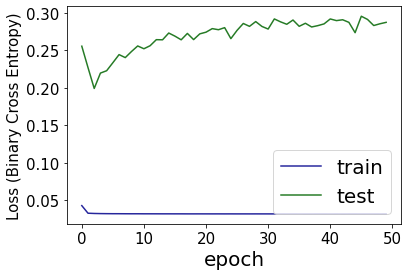

In [ ]:
 if path.isfile('./history.json'):

   history_dict = json.load(open('./history.json', 'r')) # get history json locally

else:

  history_dict = json.load(open(root+'/history.json', 'r')) # or get json from drive

plt.plot(history_dict['loss'], color='darkblue', alpha=0.85)
plt.plot(history_dict['val_loss'], color='darkgreen', alpha=0.85)
plt.ylabel('Loss (Binary Cross Entropy)', fontsize=15)
#plt.ylim((0.0,0.1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], fontsize=20)#, loc='center right')


In [ ]:
# MSE check
print('Train MSE: ', mean_squared_error(X_train, stacked_autoencoder.predict(X_train)))
print('Test MSE: ', mean_squared_error(X_test, stacked_autoencoder.predict(X_test)))


Train MSE:  0.00012493181134329368
Test MSE:  0.014701103163659501


### Using the encoder to create new features

Use the encoder part of the stacked autoencoder to generate the features for the trainind dataset. There are 10 new features and we stick them on the end of the original features.

In [ ]:
# Use the encoder to find the new features for the training dataset

X_train_encoder = encoder.predict(X_train)

print(f'The dimensions of the array containing the new features: {X_train_encoder.shape}')

# new feature names (numbering from 0-9 for now but could be 152 to 161)
new_features = [str(i) for i in range(155, 165)]
#features += new_features

# Turn the new features from X_train_encoder into a Dataframe
X_train_encoder_df = DataFrame(X_train_encoder, columns=new_features)#, columns=new_features)

X_train_encoder_df.head()


The dimensions of the array containing the new features: (97044, 10)


,155,156,157,158,159,160,161,162,163,164
0,0.427068,1.081776,1.221119,0.354288,2.237447,0.995203,1.581548,0.0,2.618568,0.741391
1,0.240213,0.485747,0.617985,0.839005,1.061017,0.380487,0.811038,0.0,1.031328,2.109435
2,0.000000,1.638344,0.590430,0.174138,1.831676,0.000000,0.787627,0.0,0.715478,1.299132
3,0.000000,2.913065,0.182367,1.043168,1.693763,0.000000,0.217793,0.0,0.499394,1.765057
4,0.000000,1.643438,0.569365,0.163942,1.831453,0.000000,0.825570,0.0,0.710125,1.294754


In [ ]:
# Add the new features merging on index (could combine with other methods)
X_train_merger = merge(X_train, X_train_encoder_df, left_index=True, right_index=True)
#from pandas import concat
#X_train_merger = concat([X_train, X_train_encoder_df], axis=1)
# Dataframe containing all the features new and old (without class label in df)
X_train_merger.head()

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
0,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36865,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.427068,1.081776,1.221119,0.354288,2.237447,0.995203,1.581548,0.0,2.618568,0.741391
1,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36867,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.240213,0.485747,0.617985,0.839005,1.061017,0.380487,0.811038,0.0,1.031328,2.109435
2,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36871,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.000000,1.638344,0.590430,0.174138,1.831676,0.000000,0.787627,0.0,0.715478,1.299132
3,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36876,0,0,0,0,...,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.000000,2.913065,0.182367,1.043168,1.693763,0.000000,0.217793,0.0,0.499394,1.765057
4,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36880,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.000000,1.643438,0.569365,0.163942,1.831453,0.000000,0.825570,0.0,0.710125,1.294754


The new features need to be scaled between 0 and 1.
X_train_scaled will be the dataset we will used for training the algorithms and performing feature selection on.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_train_scaled = scaler.fit_transform(X_train_merger) 
X_train_scaled = DataFrame(X_train_scaled, columns=X_train_merger.columns)
X_train_scaled.head()

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
0,0.0,0.0,0.0,0.000064,0.000064,0.009150,0.009150,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394895,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.137976,0.195953,0.247935,0.105813,0.689332,0.238050,0.703784,0.0,0.720722,0.247346
1,0.0,0.0,0.0,0.000012,0.000012,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394916,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077608,0.087988,0.125475,0.250582,0.326887,0.091012,0.360909,0.0,0.283858,0.703758
2,0.0,0.0,0.0,0.036308,0.036308,0.070588,0.070588,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.296770,0.119880,0.052009,0.564319,0.000000,0.350491,0.0,0.196925,0.433421
3,0.0,0.0,0.0,0.005238,0.005238,0.094771,0.094771,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395013,0.0,0.0,0.0,0.0,...,0.0,1.0,0.500006,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.527673,0.037028,0.311558,0.521829,0.000000,0.096917,0.0,0.137451,0.588865
4,0.0,0.0,0.0,0.035887,0.035887,0.070588,0.070588,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.297693,0.115603,0.048964,0.564250,0.000000,0.367376,0.0,0.195451,0.431961


We need the testing dataset to also have the same features. Use the encoder again.

In [ ]:
# Use the encoder to find the new features for the testing dataset

X_test_encoder = encoder.predict(X_test)

print('Dimension of the array of new features: ', X_test_encoder.shape)


X_test_encoder_df = DataFrame(X_test_encoder, index=range(X_test_encoder.shape[0]), columns=new_features)

X_test_encoder_df.head()

# Add the new features to the 

X_test_merger = merge(X_test, X_test_encoder_df, left_index=True, right_index=True)

# Dataframe containing all the features new and old (without class label in df)
print('Dimensions of dataframe with testing orignal + new features: ', X_test_merger.shape)
X_test_merger.head()


Dimension of the array of new features:  (40158, 10)
Dimensions of dataframe with testing orignal + new features:  (40158, 162)


,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
0,0,0,0,0.002547,0.002547,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88219,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.22215,0.0,0.47729,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0.419004,1.314072,0.670318,2.914412,1.156170,1.226008,0.200511,0.0,2.055618,0.498393
1,0,0,0,0.003296,0.003296,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.35106,0.0,0.18516,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0.254464,1.370185,0.594787,2.789084,1.305072,1.336004,0.268288,0.0,1.889158,0.559650
2,0,0,0,0.003285,0.003285,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.43700,0.0,0.47541,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0.333333,1.290656,0.495579,2.798619,1.187416,1.383481,0.170726,0.0,1.930585,0.498621
3,0,0,0,0.005942,0.005942,0.00000,0.00000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.00000,0.000000,0.005217,0.602676,1.414515,1.485451,0.703406,0.771733,0.0,0.647223,1.609370
4,0,0,0,0.001519,0.001519,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.63621,0.0,0.89971,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0.493772,2.458031,0.765486,2.406045,0.615011,1.478334,0.103813,0.0,2.627747,1.195382


Scale the new features for testing

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_test_scaled = scaler.fit_transform(X_test_merger) 
set_printoptions(precision=3) 
X_test_scaled = DataFrame(X_test_scaled, columns=X_test_merger.columns)
X_test_scaled.head()

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
0,0.0,0.0,0.0,0.002809,0.002809,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901749,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222181,0.0,0.477300,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.151015,0.234549,0.142246,0.855621,0.291662,0.296202,0.080188,0.0,0.621870,0.195526
1,0.0,0.0,0.0,0.003637,0.003637,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351109,0.0,0.185164,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.091712,0.244565,0.126218,0.818827,0.329224,0.322777,0.107293,0.0,0.571512,0.219557
2,0.0,0.0,0.0,0.003624,0.003624,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.437061,0.0,0.475420,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.120138,0.230370,0.105165,0.821626,0.299544,0.334248,0.068276,0.0,0.584045,0.195615
3,0.0,0.0,0.0,0.006561,0.006561,0.00000,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000931,0.127892,0.415277,0.374728,0.169942,0.308629,0.0,0.195799,0.631376
4,0.0,0.0,0.0,0.001672,0.001672,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636299,0.0,0.899728,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.177962,0.438735,0.162441,0.706373,0.155146,0.357164,0.041516,0.0,0.794952,0.468963


### Checking the scaling with describe

In [ ]:
X_train_scaled.describe()

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
count,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.0,97044.000000,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,...,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.00000,97044.0,97044.0,97044.0,97044.0,97044.00000,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.000000,97044.000000
mean,0.0,0.0,0.0,0.006387,0.006387,0.193837,0.193837,0.0,0.0,0.0,0.0,0.999784,0.999784,0.999784,0.0,0.999784,0.0,0.999784,0.0,0.0,0.0,0.0,0.0,0.999784,0.0,0.0,0.999784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764569,0.0,0.0,0.0,0.0,...,0.001483,0.021537,0.010774,0.020782,0.021537,0.021537,0.0,0.0,0.00001,0.0,0.0,0.0,0.0,0.00001,0.0,0.273149,0.003775,0.261462,0.005572,0.000400,0.028436,0.028436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178474,0.313042,0.125088,0.137793,0.257341,0.264482,0.195498,0.329522,0.0,0.219162,0.273155
std,0.0,0.0,0.0,0.015883,0.015883,0.354444,0.354444,0.0,0.0,0.0,0.0,0.014709,0.014709,0.014709,0.0,0.014709,0.0,0.014709,0.0,0.0,0.0,0.0,0.0,0.014709,0.0,0.0,0.014709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117626,0.0,0.0,0.0,0.0,...,0.038187,0.145165,0.072636,0.141320,0.145165,0.145165,0.0,0.0,0.00321,0.0,0.0,0.0,0.0,0.00321,0.0,0.260131,0.036295,0.262518,0.060826,0.015372,0.062765,0.062765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.172434,0.165364,0.106083,0.272437,0.220306,0.133576,0.137516,0.0,0.220450,0.249392
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.001471,0.001471,0.037908,0.037908,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700640,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.177031,0.000000,0.067112,0.000000,0.078479,0.099443,0.265515,0.0,0.038076,0.035320
50%,0.0,0.0,0.0,0.003785,0.003785,0.037908,0.037908,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.811117,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.325880,0.000000,0.201342,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023873,0.366355,0.016221,0.116491,0.220990,0.199818,0.160451,0.356901,0.0,0.112124,0.217882
75%,0.0,0.0,0.0,0.006043,0.006043,0.054902,0.054902,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.822193,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.44667

In [ ]:
X_test_scaled.describe()

,1,2,3,5,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,...,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164
count,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,...,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.000000
mean,0.0,0.0,0.0,0.005609,0.005609,0.200639,0.200639,0.0,0.0,0.0,0.0,0.999701,0.999701,0.999701,0.0,0.999701,0.0,0.999701,0.0,0.0,0.0,0.0,0.0,0.999701,0.0,0.0,0.999701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.965111,0.0,0.0,0.0,0.0,...,0.004051,0.031401,0.031401,0.029645,0.031401,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121969,0.045437,0.196163,0.009374,0.011528,0.028011,0.028011,0.0,0.000025,0.0,0.0,0.0,0.0,0.0,0.185022,0.428756,0.099231,0.267682,0.455404,0.322300,0.234145,0.290275,0.0,0.288851,0.219011
std,0.0,0.0,0.0,0.017896,0.017896,0.371463,0.371463,0.0,0.0,0.0,0.0,0.017284,0.017284,0.017284,0.0,0.017284,0.0,0.017284,0.0,0.0,0.0,0.0,0.0,0.017284,0.0,0.0,0.017284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041098,0.0,0.0,0.0,0.0,...,0.060856,0.174401,0.174401,0.167001,0.174401,0.174401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249727,0.114639,0.310219,0.079168,0.084312,0.062511,0.062511,0.0,0.004990,0.0,0.0,0.0,0.0,0.0,0.377552,0.310524,0.156926,0.147444,0.205319,0.151466,0.125446,0.142704,0.0,0.194259,0.263620
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.0,0.0,0.0,0.001499,0.001499,0.016993,0.016993,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.925995,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.002652,0.100039,0.000000,0.151268,0.363031,0.247719,0.163440,0.204220,0.0,0.148505,0.000000
50%,0.0,0.0,0.0,0.002494,0.002494,0.016993,0.016993,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988858,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.002652,0.566892,0.000000,0.291777,0.395193,0.284495,0.221922,0.319642,0.0,0.195350,0.096589
75%,0.0,0.0,0.0,0.003489,0.003489,0.060131,0.060131,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997138,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028017,0.000000,0.369895,0.0000

## Feature Selection

### Remove correlated features

In [ ]:
'''
corr = X_train_scaled.corr()
#X_train_scaled2 = X_train_scaled
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X_train_scaled.columns[columns]
X_train_scaled = X_train_scaled[selected_columns]

print('After the correlation filter, the new dimensions are:', X_train_scaled.shape)

features = X_train_scaled.columns
print('The features left are: ', features)
'''

After the correlation filter, the new dimensions are: (97044, 130)
The features left are:  Int64Index([  0,   1,   2,   3,   5,   7,   8,   9,  10,  11,
            ...
            150, 152, 153, 154, 155, 156, 157, 158, 159, 160],
           dtype='int64', length=130)


### Mutual Information Filter

I first used Mutual Information to filter out any features with zero MI with the target variable. These have zero relevance. There are many ways to feature
select. I could also remove correlated features.

In [ ]:
# Mutual Information Filter
%%time
print('Starting size of dataset: ', X_train_scaled.shape)
features=X_train_scaled.columns
# calculate MI
MI_array = mutual_info_classif(X_train_scaled, Y_train)
#MI_array = mutual_info_classif(X_train, Y_train )
print('Number of features before MI filter: ', MI_array.shape)

# new features
features_kept = []

for i in range(len(MI_array)):
  if MI_array[i] > 0:
      features_kept.append(features[i])

  #elif MI_array[i] == 0:
    #if features[i] in X_train_scaled.columns:
      #X_train_scaled.drop(features[i], axis=1, inplace=True)

#X_train_scaled = X_train_scaled[features_kept]
print('The features selected after removing features with zero MI with target: ', features_kept)
print('Number of features after filter (should be same as no. of columns in X_train_scaled now): ', len(features_kept))

#X_train_scaled.head()
#features=X_train _scaled.columns
MI_top_20 = sorted(list(zip(MI_array, features)), reverse=True)[:20]
print(MI_top_20)

Starting size of dataset:  (97044, 162)
Number of features before MI filter:  (162,)
The features selected after removing features with zero MI with target:  ['1', '5', '6', '8', '9', '11', '12', '14', '15', '16', '17', '18', '19', '20', '22', '24', '25', '26', '27', '28', '29', '32', '33', '34', '35', '36', '38', '40', '41', '43', '44', '45', '47', '48', '50', '51', '52', '54', '55', '57', '58', '59', '61', '62', '64', '66', '67', '68', '70', '71', '73', '74', '75', '76', '77', '78', '79', '80', '82', '84', '85', '87', '89', '92', '93', '94', '96', '97', '98', '100', '103', '104', '105', '106', '107', '108', '109', '110', '112', '113', '116', '118', '119', '120', '121', '122', '123', '124', '126', '127', '128', '129', '130', '131', '132', '135', '136', '139', '140', '141', '142', '143', '144', '145', '146', '149', '150', '152', '154', '155', '156', '157', '158', '159', '160', '161', '163', '164']
Number of features after filter (should be same as no. of columns in X_train_scaled now):

In [ ]:
print(X_test_scaled.columns)
print(features)

Index(['1', '2', '3', '5', '6', '8', '9', '10', '11', '12',
       ...
       '155', '156', '157', '158', '159', '160', '161', '162', '163', '164'],
      dtype='object', length=162)
Index(['1', '2', '3', '5', '6', '8', '9', '10', '11', '12',
       ...
       '155', '156', '157', '158', '159', '160', '161', '162', '163', '164'],
      dtype='object', length=162)


There's still quite a lot of features left. Let's take the top 20 highest MI with the target.

In [ ]:
# sort in order of decreasing MI
#MI_top_20 = sorted(list(zip(MI_array, features)), reverse=True)[:20]

print('Highest MI values and their features: ', MI_top_20, end='\n\n')

count=0
kept_generated_features = []

features_MI_top_20 = [x[1] for x in MI_top_20]

for feat in features_MI_top_20:
  if int(feat) >= 155:
    count+=1
    kept_generated_features.append(feat)

print(f'There are {count} generated features in the top 20 ranked by MI. These are: ', kept_generated_features) 
print()
print('Here are all the top 20 after MI selection: ', features_MI_top_20) # best features from MI
X_train_scaled = X_train_scaled[features_MI_top_20] # keep only top 20

X_train_scaled.head()


Highest MI values and their features:  [(0.6486069589377585, '38'), (0.6337928234392786, '9'), (0.6332737217553668, '8'), (0.5815740552965218, '82'), (0.5701231170353578, '159'), (0.5530693100217068, '156'), (0.49812352546003025, '163'), (0.4876793209093728, '158'), (0.4829433165074828, '164'), (0.47234201040476287, '67')]

There are 5 generated features in the top 20 ranked by MI. These are:  ['159', '156', '163', '158', '164']

Here are all the top 20 after MI selection:  ['38', '9', '8', '82', '159', '156', '163', '158', '164', '67']


,38,9,8,82,159,156,163,158,164,67
0,0.394895,0.009150,0.009150,0.946280,0.689332,0.195953,0.720722,0.105813,0.247346,0.30769
1,0.394916,0.000000,0.000000,0.000000,0.326887,0.087988,0.283858,0.250582,0.703758,1.00000
2,0.394959,0.070588,0.070588,0.255430,0.564319,0.296770,0.196925,0.052009,0.433421,0.61538
3,0.395013,0.094771,0.094771,0.072772,0.521829,0.527673,0.137451,0.311558,0.588865,0.61538
4,0.395055,0.070588,0.070588,0.256900,0.564250,0.297693,0.195451,0.048964,0.431961,0.61538


### Tree Wrapper

I then use an extremely-randomised tree classifier to rank feature importance.
Remember that the numbering of features starts from 0.

In [ ]:
# Tree Wrapper
%%time

model = ExtraTreesClassifier()
model.fit(X_train_scaled, Y_train)
importances = model.feature_importances_ 
wrapper_top_10 = sorted(list(zip(importances, features_MI_top_20)), reverse=True)[:10]
print('Highest importance and feature number', wrapper_top_10, end='\n\n')

final_features = [x[1] for x in wrapper_top_10]
print('Final Selected Features: ', final_features, end='\n\n')

X_train_scaled = X_train_scaled[final_features]

count=0
kept_generated_features_2 = []

for feat in final_features:
  if int(feat) >= 155:
    count+=1
    kept_generated_features_2.append(feat)


print(f'After feature selection, there are {count} generated features. These are: ', kept_generated_features_2) 
X_train_scaled.head()


Highest importance and feature number [(0.25013280715982367, '67'), (0.1396857743890479, '163'), (0.11598762624033186, '159'), (0.09886328556535692, '164'), (0.09301176486813854, '158'), (0.0818531473452155, '82'), (0.06222862694713932, '8'), (0.060275513319690395, '9'), (0.05003908585946205, '38'), (0.04792236830579389, '156')]

Final Selected Features:  ['67', '163', '159', '164', '158', '82', '8', '9', '38', '156']

After feature selection, there are 5 generated features. These are:  ['163', '159', '164', '158', '156']
CPU times: user 2.72 s, sys: 7.84 ms, total: 2.73 s
Wall time: 2.73 s


In [ ]:
X_train_scaled.columns

Index(['67', '159', '163', '8', '9', '82', '158', '156', '164', '38'], dtype='object')

In [ ]:
X_train_scaled

,67,159,163,8,9,82,158,156,164,38
0,0.30769,0.689332,0.720722,0.009150,0.009150,0.946280,0.105813,0.195953,0.247346,0.394895
1,1.00000,0.326887,0.283858,0.000000,0.000000,0.000000,0.250582,0.087988,0.703758,0.394916
2,0.61538,0.564319,0.196925,0.070588,0.070588,0.255430,0.052009,0.296770,0.433421,0.394959
3,0.61538,0.521829,0.137451,0.094771,0.094771,0.072772,0.311558,0.527673,0.588865,0.395013
4,0.61538,0.564250,0.195451,0.070588,0.070588,0.256900,0.048964,0.297693,0.431961,0.395055
...,...,...,...,...,...,...,...,...,...,...
97039,0.61538,0.781382,0.142464,0.038562,0.038562,0.217830,0.244568,0.225130,0.415328,0.999904
97040,0.61538,0.804971,0.149586,0.038562,0.038562,0.218320,0.251375,0.249548,0.450307,0.999936
97041,0.61538,0.778248,0.141386,0.038562,0.038562,0.218560,0.242545,0.221115,0.410157,0.999957
97042,0.61538,0.840808,0.159977,0.038562,0.038562,0.218800,0.258624,0.283726,0.503849,0.999979


### Data visualisation on new features

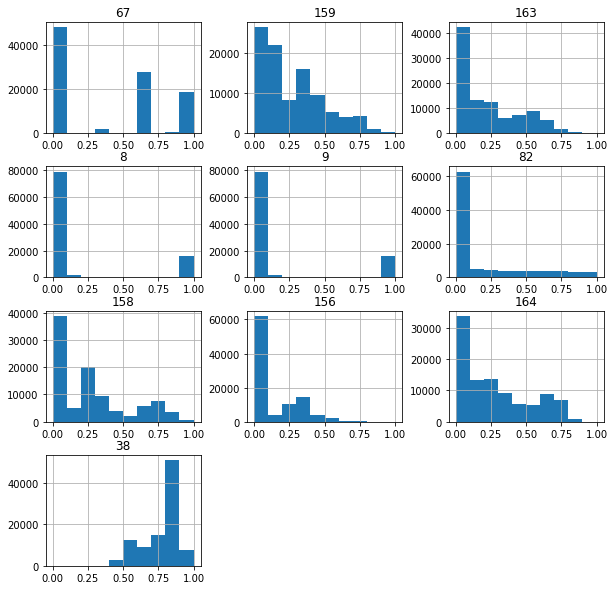

In [ ]:
X_train_scaled.hist(figsize=(10,10))
plt.show()

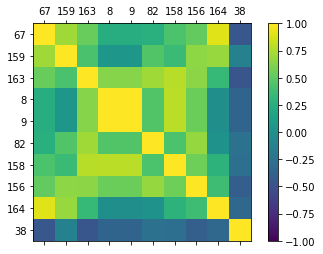

In [ ]:
# Correlation Matrix Plot
'''
correlations = X_train_scaled.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

'''
correlations = X_train_scaled.corr() 
# plot correlation matrix 
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, vmin=-1, vmax=1) 
fig.colorbar(cax) 
ticks = np.arange(0,10,1) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
ax.set_xticklabels(X_train_scaled.columns) 
ax.set_yticklabels(X_train_scaled.columns) 
plt.show()

In [ ]:
X_train_scaled.columns

Index(['67', '159', '163', '8', '9', '82', '158', '156', '164', '38'], dtype='object')

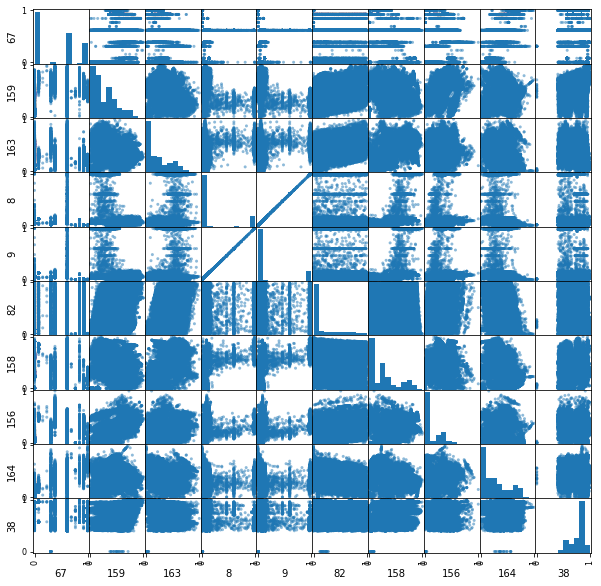

In [ ]:
from pandas.plotting import scatter_matrix 
scatter_matrix(X_train_scaled, figsize=[10, 10]) 
plt.show()

We have to remove the same columns in the testing set.

In [ ]:
# Make sure the testing dataset has the same columns

X_test_scaled = X_test_scaled[[x[1] for x in wrapper_top_10]]
print(X_test_scaled.shape)
X_test_scaled.head()

(40158, 10)


,67,159,163,8,9,82,158,156,164,38
0,0.61538,0.291662,0.621870,0.98824,0.98824,0.57753,0.855621,0.234549,0.195526,0.901749
1,0.61538,0.329224,0.571512,0.98824,0.98824,0.58559,0.818827,0.244565,0.219557,0.901759
2,0.61538,0.299544,0.584045,0.98824,0.98824,0.59096,0.821626,0.230370,0.195615,0.901759
3,1.00000,0.374728,0.195799,0.00000,0.00000,0.00000,0.415277,0.000931,0.631376,0.901759
4,0.61538,0.155146,0.794952,0.98824,0.98824,0.60342,0.706373,0.438735,0.468963,0.901759


Save the scaled test and train features to google drive since they are import dataframes.

In [ ]:
try:
  X_test_scaled.to_csv(root+'X_test_scaled.csv', index=False)
  X_train_scaled.to_csv(root+'X_train_scaled.csv', index=False)

except Exception as e:
  print(e)

## Building ML Algorithms

### Short listing algorithms with cross-validation

In [ ]:
# X and Y values for input and output arrays
try:
  if path.isdir(root):
    X_train_scaled = read_csv(root+'X_train_scaled.csv')
    X_test_scaled = read_csv(root+'X_test_scaled.csv')
    print(f'Successfully loaded scaled training {X_train_scaled.shape} and testing datasets {X_test_scaled.shape}')
except Exception as e:
  print(e)

try:
  X = X_train_scaled.values
  Y = Y_train.values
except Exception as e:
  print(e)

print(X_train_scaled.describe())
print(X_test_scaled.describe())

Successfully loaded scaled training (97044, 10) and testing datasets (40158, 10)
                 67           159  ...           164            38
count  97044.000000  97044.000000  ...  97044.000000  97044.000000
mean       0.376979      0.264482  ...      0.273155      0.764569
std        0.395372      0.220306  ...      0.249392      0.117626
min        0.000000      0.000000  ...      0.000000      0.000000
25%        0.000000      0.078479  ...      0.035320      0.700640
50%        0.307690      0.199818  ...      0.217882      0.811117
75%        0.615380      0.399767  ...      0.454770      0.822193
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 10 columns]
                 67           159  ...           164            38
count  40158.000000  40158.000000  ...  40158.000000  40158.000000
mean       0.341793      0.322300  ...      0.219011      0.965111
std        0.385898      0.151466  ...      0.263620      0.041098
min        0.000000      

First I created a neural network classifier (MLP). One neuron for output for binary classifier (on or off).

In [ ]:
# MLP Classifier

def create_MLP_model():
    model = Sequential()
    model.add(Dense(12, input_dim=10, activation='relu')) 
    model.add(Dense(8, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def build_MLP():
  model = create_MLP_model()
  return KerasClassifier(build_fn=create_MLP_model, epochs=3, batch_size=10, verbose=0)

The next cell takes a while to run. It's going to do 10-fold CV
on a bunch of different algoritms to see which perform best based on accuracy.

In [ ]:
%%time
# SHORT-LISTING ALGORITHMS



# Models for CV
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('ET', ExtraTreesClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - taking too long
models.append(('MLP', build_MLP()))


results = []
names = []
scoring = 'accuracy'

for name, model in models:
 kfold = KFold(n_splits=10, random_state=7,shuffle=True) # 10-FOLD
 cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)


LR: 0.972920 (0.001411)
ET: 0.999856 (0.000124)
XGB: 0.999753 (0.000124)
KNN: 0.999176 (0.000265)
CART: 0.999341 (0.000303)
RF: 0.999887 (0.000072)
NB: 0.957514 (0.002969)
MLP: 0.994951 (0.001189)
CPU times: user 9min 57s, sys: 28.5 s, total: 10min 25s
Wall time: 9min 10s


Boxplots subplots to show the CV performance of each algorithm.

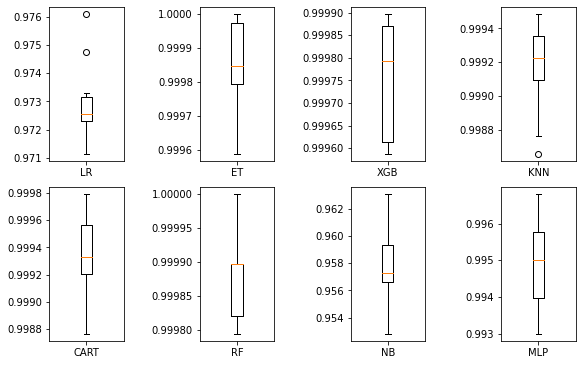

In [ ]:
x, y = 2, 4
fig, ax = plt.subplots(x, y)
fig.tight_layout(pad=0, h_pad=0, w_pad=2)
fig.set_figheight(5)
fig.set_figwidth(8)

# same box plots on separate figures
for i in range(1, len(names)+1):
  plt.subplot(x, y, i)
  plt.boxplot(results[i-1])
  plt.xticks([1], [names[i-1]])
  

plt.show()

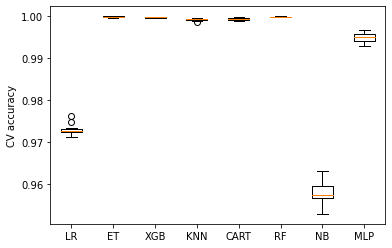

In [ ]:
# boxplot algorithm comparison

fig = plt.figure() 
#fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
plt.ylabel('CV accuracy')
ax.set_xticklabels(names) 
plt.show()

The best performing algorithms are ET, XGB and RF. Let's take them to the next
stage: Tuning. They also ran relatively quickly.

## Tuning

### Random Forest tuning

Start by applying a Grid search for Random Forest

Will only tune again if you don't have the model saved.

In [ ]:
%%time
# Grid Search for Algorithm Tuning

if path.isfile(root+'RF_tuned.sav'):
  with open(root+'RF_tuned.sav', 'rb') as f:
    RF_tuned = pickle.load(f)


elif path.isfile('./RF_tuned.sav'):
   with open('RF_tuned.sav', 'rb') as f:
    RF_tuned = pickle.load(f)

else:

  # Define parameters
  #max_depth=[8, 16, 20]
  #n_estimators = [25, 50, 100]
  param_grid = { 
    'n_estimators': [100, 200, 500],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
  }
  # Create the parameter grid
  #param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

  # Build the gridsearch
  model = RandomForestClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)# scoring='roc_auc')
  grid_results = grid.fit(X, Y)# X = X_training dataset full

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  RF_tuned = grid_results.best_estimator_
  
  #save
  try:
    with open(root+'RF_tuned.sav', 'wb') as f:
      pickle.dump(RF_tuned, f)

  except:
    with open('RF_tuned.sav', 'wb') as f:
      pickle.dump(RF_tuned, f)


Best CV accuracy for classifier: [0.9007627  0.90172102 0.90176224 0.90096879 0.90018565 0.90020626], using {'criterion': 'gini', 'n_estimators': 500}
CPU times: user 11min 41s, sys: 2.41 s, total: 11min 44s
Wall time: 11min 41s


### XGBoost tuning


Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree)

Tune regularization parameters (lambda, alpha)

Colab has restarted a few times here because I think the paramater grid was too large.

In [ ]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'XGB_tuned.sav'):
  with open(root+'XGB_tuned.sav', 'rb') as f:
    XGB_tuned = pickle.load(f)


elif path.isfile('./XGB_tuned.sav'):
   with open('XGB_tuned.sav', 'rb') as f:
    XGB_tuned = pickle.load(f)

else:
  

  # Define parameters
  param_grid = {
          'max_depth': [5, 10, 20],
          #'min_child_weight': np.arange(0.01, 0.5, 0.01),
          #'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.5, 1],
          #'learning_rate': [0.05, 0.1, 0.2, 0.3],
          #'subsample': [0.6, 0.8, 1.0],
          #'colsample_bytree': np.arange(0.1,1.0,0.1),
          'reg_alpha': [0.1, 0.2, 0.3],
          #'reg_lambda': np.arange(0, 1, 0.2)
          }

  # Do the gridsearch
  model = XGBClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X_train_scaled, Y_train)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for XGB: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  XGB_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'XGB_tuned.sav', 'wb') as f:
      pickle.dump(XGB_tuned, f)

  except:
    with open('XGB_tuned.sav', 'wb') as f:
      pickle.dump(XGB_tuned, f)

Best CV accuracy for classifier for XGB: [0.89714583 0.89724887 0.89715613 0.89719735 0.89719735 0.89721796
 0.89717674 0.89719735 0.89716643 0.89715613 0.89717674 0.89716643
 0.89717674 0.89890789 0.89718704 0.89717674 0.89717674 0.89717674
 0.89717674 0.89725917 0.89715613 0.89723857 0.89717674 0.89720765
 0.89723857 0.89717674 0.89720765], using {'gamma': 0.5, 'max_depth': 10, 'reg_alpha': 0.2}
CPU times: user 16min 42s, sys: 1.9 s, total: 16min 44s
Wall time: 16min 39s


### Extra-Tree tuning

In [ ]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'ET_tuned.sav'):
  with open(root+'ET_tuned.sav', 'rb') as f:
    ET_tuned = pickle.load(f)


elif path.isfile('./ET_tuned.sav'):
   with open('ET_tuned.sav', 'rb') as f:
    ET_tuned = pickle.load(f)

else:
  # Define parameters
  param_grid = { 
  'n_estimators': [200, 500],
  'max_features': ['auto', 'sqrt', 'log2'],
  'max_depth' : [4,5,6,7,8],
  'criterion' :['gini', 'entropy']
  }

  # Do the gridsearch
  model = ExtraTreesClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X, Y)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for ET: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  ET_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'ET_tuned.sav', 'wb') as f:
      pickle.dump(ET_tuned, f)

  except:
    with open('ET_tuned.sav', 'wb') as f:
      pickle.dump(ET_tuned, f)

Best CV accuracy for classifier for ET: [0.95246343 0.95364851 0.95377217 0.95356607 0.95377217 0.95408132
 0.96281974 0.96412851 0.96190262 0.96036729 0.96429329 0.95991375
 0.97280511 0.97265053 0.97260929 0.97225892 0.97034218 0.97257838
 0.97671068 0.97648396 0.97635    0.9744951  0.97223829 0.97682403
 0.97982278 0.98098725 0.98001857 0.97794727 0.97776178 0.98003918
 0.95361759 0.95366912 0.95442139 0.95328784 0.95273136 0.95386492
 0.96340716 0.95821343 0.96533422 0.96167593 0.95668838 0.95981078
 0.97336155 0.97301119 0.97310394 0.97208375 0.97154787 0.97138302
 0.97868924 0.97666946 0.97971974 0.97478364 0.97516493 0.97235165
 0.97850374 0.98157464 0.98119335 0.98094603 0.98078115 0.98034834], using {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
CPU times: user 33min 9s, sys: 17.4 s, total: 33min 26s
Wall time: 33min 20s


### KNN tuning

In [ ]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'KNN_tuned.sav'):
  with open(root+'KNN_tuned.sav', 'rb') as f:
    KNN_tuned = pickle.load(f)


elif path.isfile('./KNN_tuned.sav'):
   with open('KNN_tuned.sav', 'rb') as f:
    KNN_tuned = pickle.load(f)

else:

  # Do the gridsearch


  k_range = list(range(1, 31))
  param_grid = dict(n_neighbors=k_range)
  
  model = KNeighborsClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X, Y)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for ET: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  KNN_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'KNN_tuned.sav', 'wb') as f:
      pickle.dump(KNN_tuned, f)

  except:
    with open('KNN_tuned.sav', 'wb') as f:
      pickle.dump(KNN_tuned, f)

CPU times: user 21.8 ms, sys: 37.1 ms, total: 58.9 ms
Wall time: 109 ms


### LR tuning

In [ ]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'LR_tuned.sav'):
  with open(root+'LR_tuned.sav', 'rb') as f:
    LR_tuned = pickle.load(f)


#elif path.isfile('./LR_tuned.sav'):
   #with open('LR_tuned.sav', 'rb') as f:
    #LR_tuned = pickle.load(f)

else:

  # Do the gridsearch

  param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
  
  model = LogisticRegression()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X, Y)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for LR: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  LR_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'LR_tuned.sav', 'wb') as f:
      pickle.dump(LR_tuned, f)

  except:
    with open('LR_tuned.sav', 'wb') as f:
      pickle.dump(LR_tuned, f)

CPU times: user 2.44 ms, sys: 622 µs, total: 3.06 ms
Wall time: 428 ms


## Evaluation

Generate a report and confusion matrix for each tuned algorithm.

To run this section, make sure you loaded the algorithms by running the previous
section **Tuning**.

### Random Forest report

              precision    recall  f1-score   support

           0       0.52      1.00      0.68     20079
           1       0.98      0.07      0.13     20079

    accuracy                           0.54     40158
   macro avg       0.75      0.54      0.41     40158
weighted avg       0.75      0.54      0.41     40158

MCC:  0.18801204733788085
CPU times: user 48.9 s, sys: 275 ms, total: 49.1 s
Wall time: 48.9 s


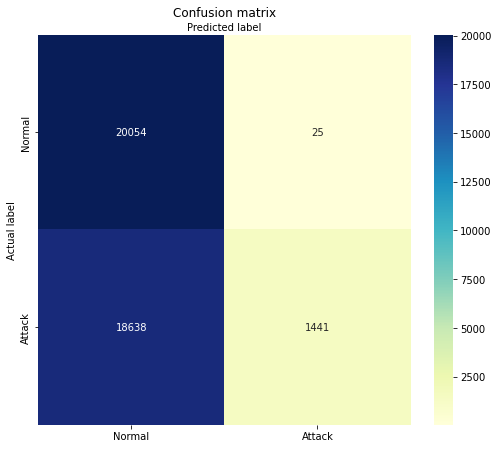

In [ ]:
%%time
# run tuning to load the tuned Random
X_test = X_test_scaled.values
RFC = RF_tuned.fit(X, Y)
#RF_tuned.fit(X_train_scaled, Y_train)
predicted = RF_tuned.predict(X_test_scaled)
report = classification_report(Y_test, predicted)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
print('MCC: ', matthews_corrcoef(Y_test, predicted))

### XGBoost report

              precision    recall  f1-score   support

           0       0.51      0.98      0.67     20079
           1       0.79      0.07      0.13     20079

    accuracy                           0.53     40158
   macro avg       0.65      0.53      0.40     40158
weighted avg       0.65      0.53      0.40     40158

0.5255739827680661


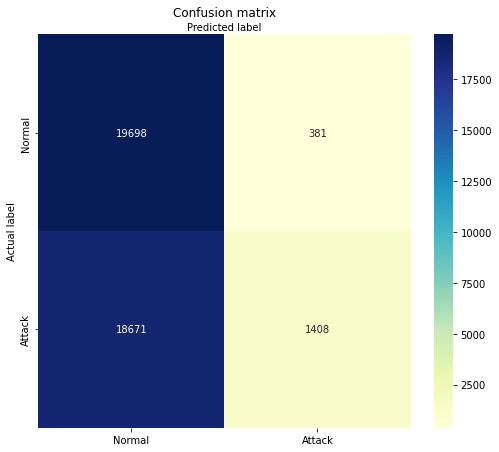

MCC:  0.1239581348870686


In [ ]:

#XGB_tuned.fit(X, Y)
XGB = XGBClassifier(gamma=0.5, max_depth=10, reg_alpha=0.2)
XGB.fit(X_train_scaled.values,Y_train)
XGB_predicted = XGB_tuned.predict(X_test_scaled)#X_test

report = classification_report(Y_test, XGB_predicted)#Y_test
print(report)
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, XGB_predicted))
# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, XGB_predicted)# Y_test

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
plt.show()
print('MCC: ', matthews_corrcoef(Y_test, XGB_predicted))

In [ ]:
XGB_predicted

array([0, 0, 0, ..., 0, 0, 0])

### Extra-Tree classifier report

              precision    recall  f1-score   support

           0       0.52      1.00      0.68     20079
           1       0.98      0.06      0.12     20079

    accuracy                           0.53     40158
   macro avg       0.75      0.53      0.40     40158
weighted avg       0.75      0.53      0.40     40158

MCC:  0.1772639692886233
CPU times: user 13 s, sys: 187 ms, total: 13.2 s
Wall time: 13.1 s


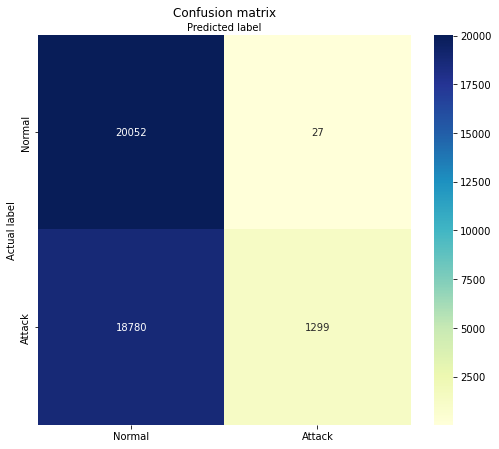

In [ ]:
%%time
# run tuning to load the tuned Random
X_test = X_test_scaled.values
ETC = ET_tuned.fit(X, Y)
#ETC = ExtraTreesClassifier(random_state=20).fit(X,Y)
ET_predicted = ETC.predict(X_test)
report = classification_report(Y_test, ET_predicted)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, ET_predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)

from sklearn.metrics import matthews_corrcoef
print('MCC: ', matthews_corrcoef(Y_test, ET_predicted))

### KNN report

              precision    recall  f1-score   support

           0       0.52      0.99      0.68     20079
           1       0.90      0.07      0.13     20079

    accuracy                           0.53     40158
   macro avg       0.71      0.53      0.41     40158
weighted avg       0.71      0.53      0.41     40158

MCC:  0.16429923002740454
CPU times: user 2.94 s, sys: 105 ms, total: 3.05 s
Wall time: 2.94 s


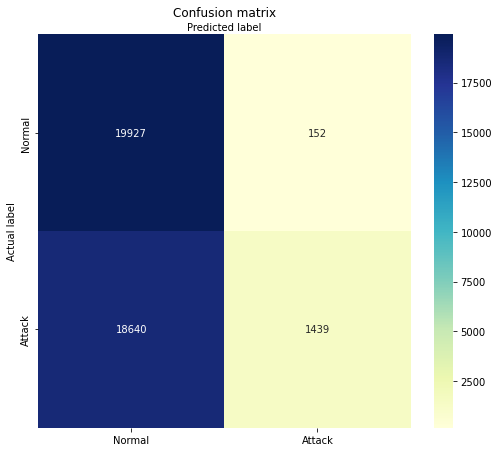

In [ ]:
%%time
X_test = X_test_scaled.values
KNN_final = KNN_tuned.fit(X, Y)
KNN_predicted = KNN_final.predict(X_test)
report = classification_report(Y_test, KNN_predicted)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, KNN_predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)

print('MCC: ', matthews_corrcoef(Y_test, KNN_predicted))

### LR report

              precision    recall  f1-score   support

           0     0.9151    0.9300    0.9225     20079
           1     0.9289    0.9137    0.9212     20079

    accuracy                         0.9219     40158
   macro avg     0.9220    0.9219    0.9219     40158
weighted avg     0.9220    0.9219    0.9219     40158

MCC:  0.8438299111634368
CPU times: user 847 ms, sys: 593 ms, total: 1.44 s
Wall time: 758 ms


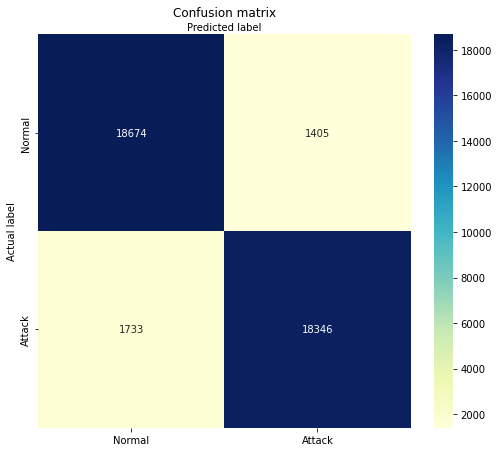

In [ ]:
%%time
X_test = X_test_scaled.values
LR_tuned = LR_tuned.fit(X, Y)
#LR_tuned = LogisticRegression(random_state=50).fit(X, Y)
LR_predicted = LR_tuned.predict(X_test)
report = classification_report(Y_test, LR_predicted, digits=4)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, LR_predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)

print('MCC: ', matthews_corrcoef(Y_test, LR_predicted))